In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2-4*x+5

In [5]:
f(3.0)

20.0

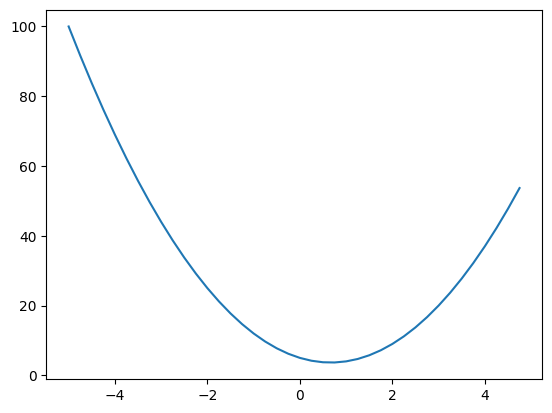

In [6]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [7]:
h=0.000001
x=2/3
(f(x+h)-f(x))/(h)

2.999378523327323e-06

In [8]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [9]:
h=0.0001

#input values
a=2.0
b=-3.0  
c=10.0

d1=a*b+c
b+=h
d2=(a)*b+c

print('d1:',d1)
print('d2:',d2)
print('slope:',(d2-d1)/h)

d1: 4.0
d2: 4.0002
slope: 2.0000000000042206


In [59]:
class Value:

    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self._prev=set(_children)
        self.grad=0.0
        self._backward=lambda : None
        self._op=_op
        self.label=label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
        return out
    
    def __radd__(self,other):
        return self+other
    
    def __rmul__(self,other):
        return self*other
    
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"only supporting int/float powers for now"
        out=Value(self.data**other,(self,),'**'+str(other))
        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward=_backward
        return out

    def __truediv__(self,other):
        return self*(other**-1)
    

    def __neg__(self):
        return self*-1
    
    def __sub__(self,other):
        return self+(-other)
    
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward
        return out 
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0  # seed gradient
        for node in reversed(topo):
            node._backward()



In [44]:
a=Value(2.0,label='x1')
b=Value(-3.0,label='x2')
a-b

Value(data=5.0)

In [11]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR: left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        # create a rectangular (record) node for the value
        dot.node(name=uid, 
                 label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
                 shape='record')

        if n._op:
            # this value is the result of some operation, create an op node
            dot.node(name=uid + n._op, label=n._op)
            # connect op node to value node
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


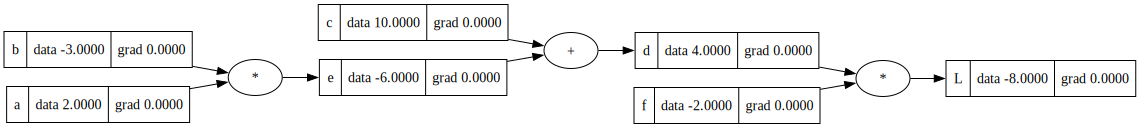

In [12]:
draw_dot(L)

In [13]:
def lol():

    h=0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0, label='f')
    L=d*f;L.label='L'
    L1=L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e=a*b;e.label='e';
    d=e+c;d.label='d';
    f=Value(-2.0, label='f')
    L=d*f;L.label='L'
    L2=L.data

    print((L2-L1)/h)

lol()

0.0


<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

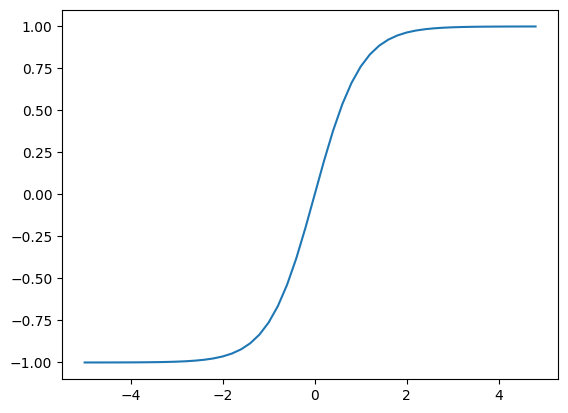

In [14]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.plot

In [63]:
#inputs x1,x2
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2') 
#weights w1,w2
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
#bias b
b=Value(6.8813735870195432,label='b')
#x1*w1 + x2*w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1w1+x2w2'
n=x1w1x2w2+b; n.label='n'
e=(2*n).exp()
o=(e-1)/(e+1)
o.label='o'


In [60]:
o.grad=1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

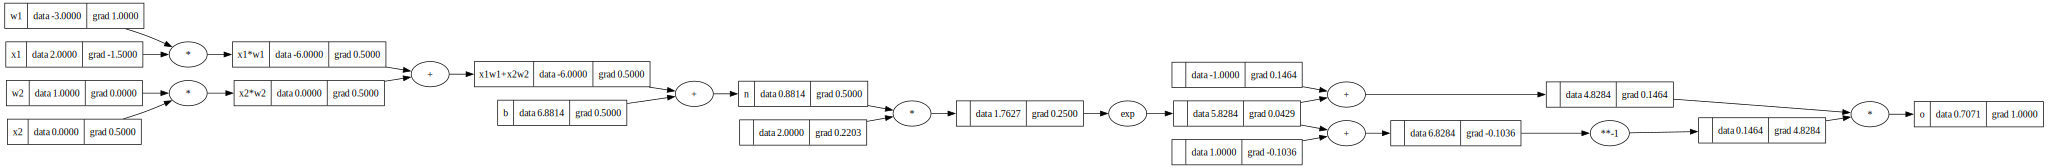

In [64]:
o.backward()
draw_dot(o)

In [40]:
topo=[]
visited=set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [88]:
class Neuron:
    def __init__(self, nin):
        self.w=[Value(np.random.randn()) for _ in range(nin)]
        self.b=Value(0.0)
    
    def __call__(self,x):
        #weighted sum
        act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        #activation function
        out=act.tanh()
        return out
    
    def parameters(self):
        return self.w+[self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self,nin,nouts):
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [90]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=0.6183318747730641)

In [93]:
n.parameters()

[Value(data=0.4337910372725412),
 Value(data=-0.7449471218953507),
 Value(data=-0.019837781472513964),
 Value(data=0.0),
 Value(data=0.39408127531295933),
 Value(data=0.7059257775357307),
 Value(data=0.7683975648201171),
 Value(data=0.0),
 Value(data=-0.012185168762573891),
 Value(data=-1.4197846824232574),
 Value(data=-1.114394866194534),
 Value(data=0.0),
 Value(data=-0.8100250495116132),
 Value(data=-1.2841074062193525),
 Value(data=0.41072473751810523),
 Value(data=0.0),
 Value(data=0.30190670655806573),
 Value(data=-0.14036486262185932),
 Value(data=-0.7570523316080188),
 Value(data=0.609481454884705),
 Value(data=0.0),
 Value(data=0.30129496526685806),
 Value(data=-0.6550086035623557),
 Value(data=-0.4705945682226306),
 Value(data=0.17360864440558255),
 Value(data=0.0),
 Value(data=-0.7955099440134804),
 Value(data=0.12560429820302593),
 Value(data=0.41939768732010885),
 Value(data=1.4249468098588038),
 Value(data=0.0),
 Value(data=1.5652842511723521),
 Value(data=-0.295014488445

In [94]:
xs=[[2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]]

ys=[1.0,-1.0,1.0,-1.0] 

ypred=[n(x) for x in xs]
ypred

[Value(data=0.6183318747730641),
 Value(data=0.923463174503999),
 Value(data=0.42102036607019466),
 Value(data=0.6010165512363911)]

In [95]:
loss=sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=6.743852555325605)

In [96]:
loss.backward()

In [97]:
n.layers[0].neurons[0].w[0].grad

-0.2399445678953386